# Word2Vec in Action

In [1]:
# IMPORTS
import re
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# My usual preferences
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
# Many of these libraries come with their own test data / toy corpora.
from gensim.test.utils import common_texts
print(common_texts[0:3])

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system']]


In [3]:
# Toy corpus
# Pretend we tokenized, lowered, and removed punctuation
sentences = [['i', 'like', 'apple', 'pie', 'for', 'dessert'],
            ['i', 'dont', 'drive', 'fast', 'cars'],
            ['data', 'science', 'is', 'fun'],
            ['chocolate', 'is', 'my', 'favorite'],
            ['my', 'favorite', 'movie', 'is', 'predator']]

## Basics of `Word2Vec`

**Word2Vec Parameters**
- `min_count` : the minimum number of times a word must occur to be included
- `size` : the length of the vector (it will otherwise create a vector for all the words)
- `window` : how many words to include on either side of the target word

In [4]:
# train word2vec model
model = Word2Vec(sentences=sentences, 
                 window = 2, 
                 min_count=1, 
                 vector_size = 5)

# Standard way to get information about the model
print(model)

# The model is stored as a numpy array,
# so we can get much the same information by getting the array's shape:
print(model.wv.get_normed_vectors().shape)

Word2Vec<vocab=19, vector_size=5, alpha=0.025>
(19, 5)


In [5]:
# Access vector for one word
print(model.wv['chocolate'])

# See words with similar usage
print(model.wv.most_similar('chocolate', topn=3))

[ 0.03717639  0.12177727 -0.09596102 -0.06214521  0.13595259]
[('predator', 0.8471102714538574), ('data', 0.8061100244522095), ('dont', 0.6006304025650024)]


In [6]:
# list the vocabulary words
model.wv.key_to_index

{'is': 0,
 'i': 1,
 'favorite': 2,
 'my': 3,
 'drive': 4,
 'like': 5,
 'apple': 6,
 'pie': 7,
 'for': 8,
 'dessert': 9,
 'dont': 10,
 'predator': 11,
 'fast': 12,
 'movie': 13,
 'data': 14,
 'science': 15,
 'fun': 16,
 'chocolate': 17,
 'cars': 18}

In [7]:
model.wv.get_normed_vectors()

array([[-0.03849567,  0.01697168,  0.3662972 ,  0.64664733, -0.66776013],
       [-0.48855633,  0.4433902 ,  0.6159798 , -0.34430027, -0.25834882],
       [ 0.6150827 , -0.12779771, -0.37807605,  0.546207  , -0.40504012],
       [-0.13908541,  0.2203119 ,  0.07596576, -0.6345492 , -0.7236674 ],
       [ 0.56792194,  0.39380786,  0.52490705,  0.05931308,  0.49328956],
       [-0.31370667, -0.0871837 ,  0.53140837, -0.69290286, -0.3625989 ],
       [-0.52173674, -0.06459854,  0.6624952 , -0.508372  , -0.16209805],
       [-0.17209898,  0.7173913 , -0.52674794,  0.00401107, -0.42219922],
       [-0.6575294 ,  0.34283596, -0.5997454 , -0.30069652, -0.0024032 ],
       [-0.01832273, -0.47394884,  0.5947988 ,  0.30820608,  0.57119185],
       [-0.6135583 ,  0.33812973, -0.31115016,  0.0620135 ,  0.63918257],
       [-0.32604057,  0.33008295, -0.49590695, -0.25927958,  0.6867265 ],
       [-0.17525703,  0.03570027, -0.45997098, -0.8534484 , -0.16752042],
       [ 0.3487878 , -0.1254084 ,  0.7

### Visualization

In [8]:
# We get the array
X = model.wv.get_normed_vectors()

# And we set up PCA
pca = PCA(n_components=2)

# We fit the PCA to the array
result = pca.fit_transform(X)

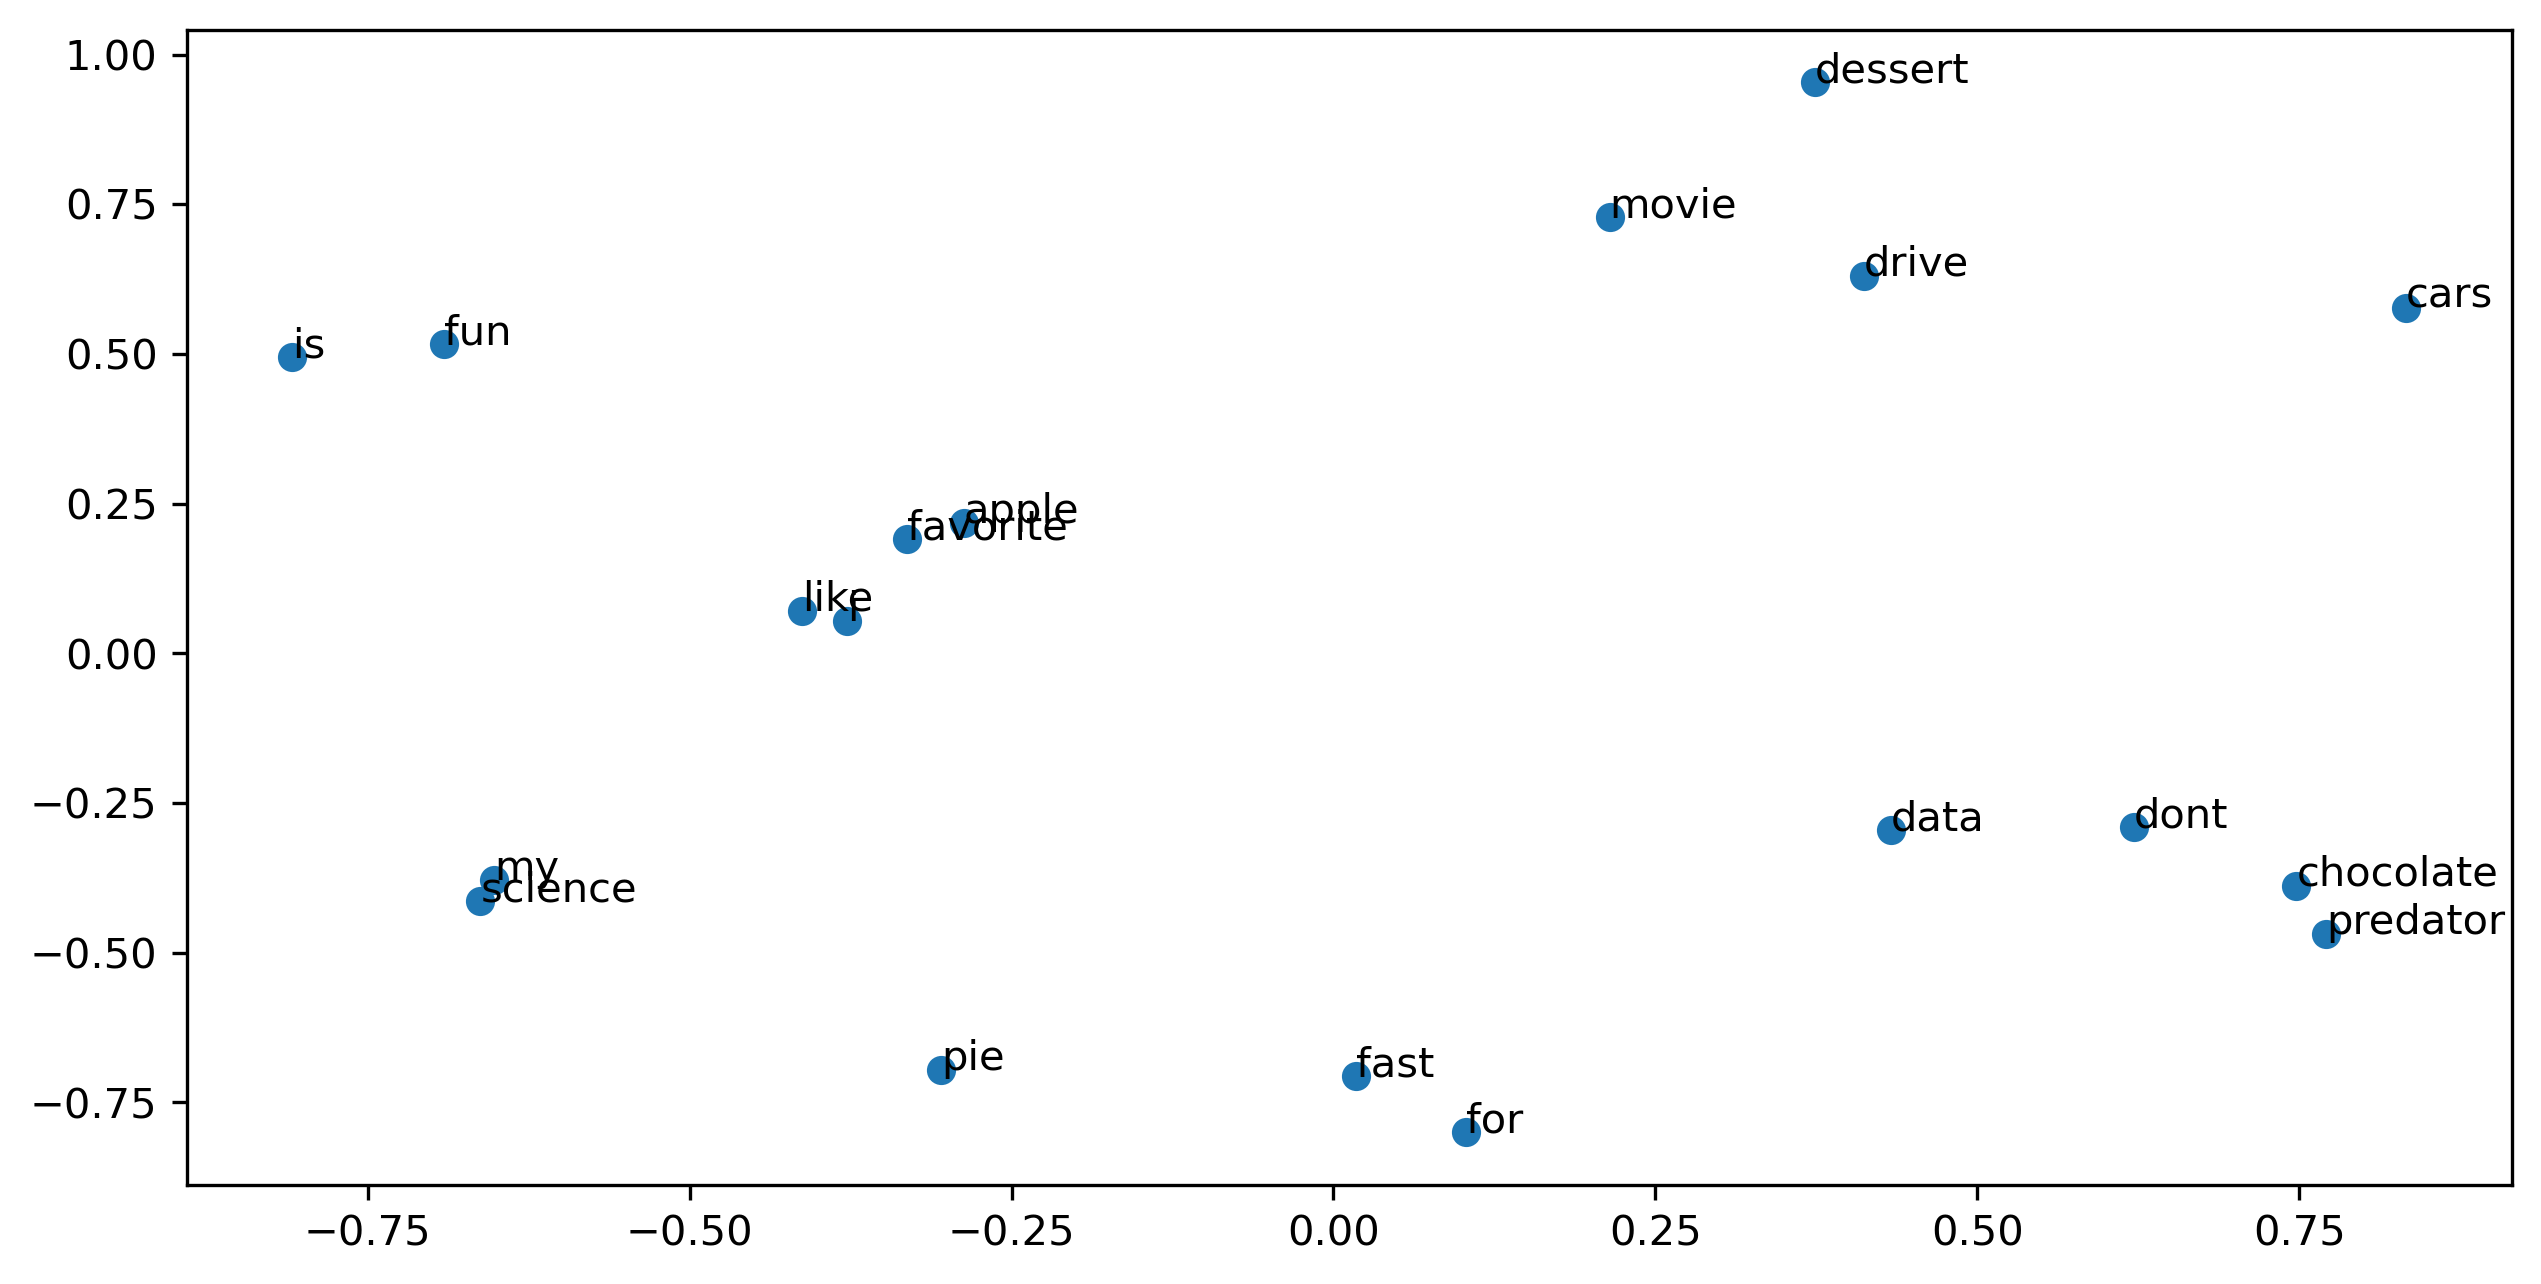

In [9]:
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

words = list(model.wv.index_to_key)

for i, word in enumerate(words):
   plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()

<div class="alert alert-block alert-info">
<b>Tip:</b> Remember, any array can be easily turned into a Pandas dataframe, which means you can do all the pandas-y things to it: sum, average, group, save to a csv (and read from a CSV and then back to an array).
</div>

In [10]:
df = pd.DataFrame(model.wv.get_normed_vectors())
df['word'] = words
df.set_index('word', inplace = True)
df.head()

,0,1,2,3,4
word,,,,,
is,-0.038496,0.016972,0.366297,0.646647,-0.667760
i,-0.488556,0.443390,0.615980,-0.344300,-0.258349
favorite,0.615083,-0.127798,-0.378076,0.546207,-0.405040
my,-0.139085,0.220312,0.075966,-0.634549,-0.723667
drive,0.567922,0.393808,0.524907,0.059313,0.493290


## Loading Data

In [11]:
# DATA
with open("../queue/gabs.txt", "r") as f:
    gabs = f.readlines()

# Make one big string
# Note the added period: not all gabs have punctuation,
# so we are forcing a sentence at least at the end of each gab.
gab_text = ". ".join(gabs)

# An empty list which we will fill with sentences to feed w2v
# Each sentence will itself be a list of tokens (words)
data = []

# Iterate through each sentence in the big string
for sentence in sent_tokenize(gab_text):
    # A list to hold our words
    temp = []
    # tokenize the sentence into words
    for word in word_tokenize(sentence):
        temp.append(word.lower())
    # Now we add the list of words to the list of sentences
    data.append(temp)

# How many "sentences" do we have?
print(len(data))

148447
